In [1]:
import sys
import os
# Append the library path to PYTHONPATH, so library can be imported.
sys.path.append(os.path.dirname(os.getcwd()))
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import norm

from library import common as cm
from library import plot
from library import regression_aux as raux

In [2]:
%run setup.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(RANDOM_SEED)
sns.set(style='darkgrid')

In [3]:
time_cols = ['ExecuteTime' + value[1] for key, value in OFFSET_DICT.items()]
df = pd.read_csv(
    DATA_DIR + f'CleanData/options.csv',
    index_col=0,
    parse_dates=['ExecuteTime0', 'FuturesExpiry', 'Expiry', 'date'] + time_cols,
    dtype={'SecurityType': 'category',
            'TrdType': 'category',
            'AggressorSide': 'category',
          'cp_int': 'int'})

/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df_real_1 = df.loc[(df['date'] > pd.Timestamp(2016, 1, 1)) & (df['date'] < pd.Timestamp(2016, 4, 1))]
df_real_2 = df.loc[(df['date'] > pd.Timestamp(2017, 7, 1)) & (df['date'] < pd.Timestamp(2017, 10, 1))]

ops_1 = df_real_1['SecurityID'].unique()
ops_2 = df_real_2['SecurityID'].unique()

bl = [(i in ops_1) or (i in ops_2) for i in df['SecurityID']]
df_real = df.loc[bl]

In [5]:
df_spot = pd.read_csv(f'{DATA_DIR}RawData/stoxx50.csv',
                     usecols=['Date', 'Last Price'], dayfirst=True,
                     parse_dates=['Date'])
df_spot.rename(columns={'Last Price': 'Spot',
                       'Date': 'date'}, inplace=True)

df_spot = df_spot.set_index('date')
df_spot = df_spot.loc[
    (df_spot.index > pd.Timestamp('2016/01/01')) & (df_spot.index < pd.Timestamp('2018/07/27'))]

/Users/rufj/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


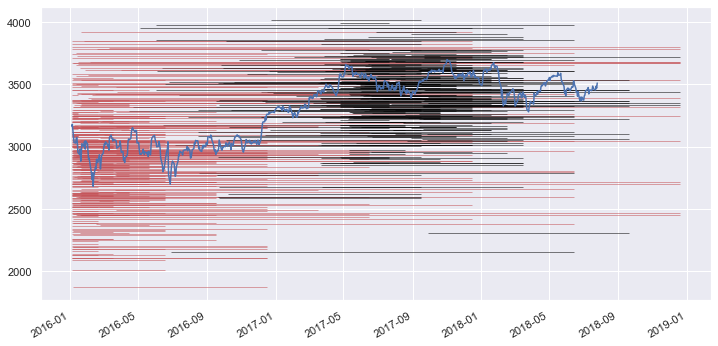

In [6]:
groups = df_real.groupby('SecurityID')

fig_, ax_ = plt.subplots(figsize=(12, 6))

for key, g in groups:
    if g.shape[0] < 1000:
        continue
    if key in ops_1:
        color='r'   
    else:
        color='black'
    ax_.hlines(y=g['K'].min() + 100*np.random.standard_normal(),
              xmin=g['date'].min(),
              xmax=g['Expiry'].max(),
              alpha=1., lw=0.5, color=color)
ax_.plot(df_spot.index, df_spot['Spot'].values)
fig_.autofmt_xdate()

In [ ]:
"""  Remember to run with 1D!!! setup , everything default."""
%run Load_Clean_aux.py

In [ ]:
" 3.2 is the maximum of maturity in the SP500 data, we do this to keep consistency of plots."
print(f"Remove time-to-maturity less than 3.2 years, {(df['tau0'] >= 3.2).sum()} samples were removed")
df = df.loc[df['tau0'] < 3.2]

In [ ]:
plt.hist(df['M0'], bins=50);
plt.xlabel('Moneyness')
plt.yscale('log')
plt.title('Euro Stoxx 50')
plt.ylim((1e3, 3e5))
plt.yticks((1e3, 1e4, 1e5), (1000, 10000, 100000))

In [ ]:
plt.hist(df['tau0'], bins=50);
plt.xlabel('Time-to-maturity')
plt.yscale('log')
plt.title('Euro Stoxx 50')
plt.ylim((1e2, 1e6))
plt.yticks((1e2, 1e3, 1e4, 1e5,  1e6), (100, 1000, 10000, 100000, 1000000))
plt.xlim((0., 3.2))

In [ ]:
df['implvol0'].hist(bins=50)

In [ ]:
df.loc[df['cp_int'] == 0, 'delta_bs'].hist(bins=50)

In [ ]:
plt.hist(norm.ppf(df.loc[df['cp_int'] == 0, 'delta_bs']), bins=50);

In [ ]:
df.loc[df['cp_int'] == 1, 'delta_bs'].hist(bins=50)

In [ ]:
x = norm.ppf(np.minimum(0.999, df.loc[df['cp_int'] == 1, 'delta_bs'] + 1))
plt.hist(x, bins=50);

In [ ]:
df_spot = pd.read_csv(f'{DATA_DIR}RawData/stoxx50.csv',
                     usecols=['Date', 'Last Price'], dayfirst=True,
                     parse_dates=['Date'])
df_spot.rename(columns={'Last Price': 'Spot',
                       'Date': 'date'}, inplace=True)

df_spot = df_spot.set_index('date')
df_spot = df_spot.loc[
    (df_spot.index > pd.Timestamp('2016/01/01')) & (df_spot.index < pd.Timestamp('2018/07/27'))]

In [ ]:
df_s = df[['S0', 'ExecuteTime0']]
df_s = df_s.set_index('ExecuteTime0')
df_s.rename(columns={'S0': 'Futures'}, inplace=True)
df_s_last = df_s.resample('D').last()

In [ ]:
df_spot_last = df_spot.resample('D').last()

fig, ax = plt.subplots(figsize=(8, 4))
df_s_last.plot(ax=ax, c='red', label='Futures')
df_spot_last.plot(ax=ax, c='black', label='Spot')
plt.legend()

In [ ]:
df_vol = df[['implvol0', 'ExecuteTime0', 'cp_int']]
df_vol = df_vol.set_index('ExecuteTime0')

In [ ]:
" Daily volatility "
df_vol.resample('D')['implvol0'].mean().plot()

In [ ]:
max_period = max([int(s[6:]) for s in df.columns if 'period' in s])

In [ ]:
nums_call_train, nums_put_train = [], []
nums_call_test, nums_put_test = [], []


for i in range(max_period + 1):
    nums_call_train.append((((df[f'period{i}'] == 0) | (df[f'period{i}'] == 1)) & (df['cp_int'] == 0)).sum())
    nums_put_train.append((((df[f'period{i}'] == 0) | (df[f'period{i}'] == 1)) & (df['cp_int'] == 1)).sum())
    nums_call_test.append(((df[f'period{i}'] == 2) & (df['cp_int'] == 0)).sum())
    nums_put_test.append(((df[f'period{i}'] == 2) & (df['cp_int'] == 1)).sum())

ind = np.arange(1, max_period+2)
width = 0.3
p1 = plt.bar(ind, nums_call_train, width=width)
p2 = plt.bar(ind, nums_put_train, bottom=nums_call_train, width=width)
p3 = plt.bar(ind+width, nums_call_test, width=width)
p4 = plt.bar(ind+width, nums_put_test, bottom=nums_call_test, width=width)
plt.legend((p1[0], p2[0], p3[0], p4[0]), 
           ('In-sample call', 'In-sample put', 'Out-of-sample call', 'Out-of-sample put'), 
           frameon=False)
plt.ylabel('# Samples')
plt.xlabel('Time window')
plt.title('Euro Stoxx 50')
plt.ylim((0., 400000))

In [ ]:
max_period = 4
if FREQ == '1D':
    num_d = 1
    annual_cof = 252 / num_d
if FREQ == '2D':
    num_d = 2
    annual_cof = 252 / num_d
if FREQ == '1H':
    num_d = 1/9
    annual_cof = 252 / num_d

In [ ]:
[df_vol_train, df_vol_test, df_return_train, df_return_test] = [pd.Series(index=range(max_period + 1)) for _ in range(4)]
for i in range(max_period + 1):
    df_train = df.loc[(df[f'period{i}'] == 0) | (df[f'period{i}'] == 1)]
    df_test = df.loc[df[f'period{i}'] == 2]
    df_train = df_train[['S0', 'S1', 'ExecuteTime0']].set_index('ExecuteTime0')
    df_test = df_test[['S0', 'S1', 'ExecuteTime0']].set_index('ExecuteTime0')
    
    for df_tmp, (df_vol_tmp, df_return_tmp) in zip([df_train, df_test], 
                                                   [(df_vol_train, df_return_train), (df_vol_test, df_return_test)]):
        window_return = np.log(df_tmp['S1'] / df_tmp['S0']).resample(FREQ).mean()
        df_vol_tmp.loc[i] = window_return.std() * np.sqrt(annual_cof)
        df_return_tmp.loc[i] = (window_return.mean()  * annual_cof)

plt.errorbar(df_vol_train.index + 1 - 0.1, df_return_train, yerr=df_vol_train, fmt='o', label='In-sample')
plt.errorbar(df_vol_test.index + 1 + 0.1, df_return_test, yerr=df_vol_test, fmt='o', label='Out-of-sample')
plt.legend(frameon=False)
plt.ylabel('Annualized return of Euro Stoxx 50')
plt.xlabel('Time window')
plt.title('1 hour')
plt.ylim((-0.4, 0.4))
plt.xticks(df_vol_train.index+1)

In [ ]:
" Average Vega "
mat = [(0, 0., 1., 'call', 'all'), 
      (1, 0., 1., 'put', 'all')]
vega_mean = pd.DataFrame(index=range(max_period))
leve = pd.DataFrame(index=range(max_period))
for i in range(max_period + 1):
    df_train = df.loc[(df[f'period{i}'] == 0) | (df[f'period{i}'] == 1)]
    for c, mat_low, mat_high, n1, n2 in mat:
        bl1 = df_train['cp_int'] == c
        bl2 = df_train['tau0'] >= mat_low
        bl3 = df_train['tau0'] < mat_high
        bl = bl1 & bl2 & bl3
        vega_mean.loc[i, f'{n1}_{n2}'] = df_train.loc[bl, 'vega_n'].mean()
        leve.loc[i, f'{n1}_{n2}'] = raux.fit_leverage(df_train.loc[bl])

vega_mean.plot(marker='o', linewidth=0)

In [ ]:
mat = [(0, 0., 1/12., 'Call', 'short'), (0, 1/12., 1/2., 'Call', 'middle'), (0, 1/2., 2., 'Call', 'long'),
      (1, 0., 1/12., 'Put', 'short'), (1, 1/12., 1/2., 'Put', 'middle'), (1, 1/2., 5., 'Put', 'long')]
vega_mean = pd.DataFrame(index=range(max_period))
leve = pd.DataFrame(index=range(max_period))
num = pd.DataFrame(index=range(max_period))

for i in range(max_period + 1):
    df_train = df.loc[(df[f'period{i}'] == 0) | (df[f'period{i}'] == 1)]
    for c, mat_low, mat_high, n1, n2 in mat:
        bl1 = df_train['cp_int'] == c
        bl2 = df_train['tau0'] >= mat_low
        bl3 = df_train['tau0'] < mat_high
        bl = bl1 & bl2 & bl3
        
        num.loc[i, f'{n1} ({n2})'] = (bl1 & bl2 & bl3).sum()
        
        vega_mean.loc[i, f'{n1} ({n2})'] = df_train.loc[bl, 'vega_n'].mean()
        leve.loc[i, f'{n1} ({n2})'] = raux.fit_leverage(df_train.loc[bl])

In [ ]:
cat = ['Put (long)', 'Call (long)', 'Put (middle)','Call (middle)', 'Put (short)' , 'Call (short)']

In [ ]:
for x in cat:
    plt.plot(leve.index+1, leve[x], marker='o', label=x, linewidth=0)
#plt.legend()
plt.ylim((-0.45, 0.5))
plt.legend(bbox_to_anchor=(0,-.35,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.xticks(leve.index+1)
plt.xlabel('Time window')
plt.ylabel('Leverage coefficient')
plt.title('Euro Stoxx 50')